# Real Estate Ad Quality Assistant

## Importing Libraries

In [ ]:
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

from torch import __version__; from packaging.version import Version as V
xformers = "xformers==0.0.27" if V(__version__) < V("2.4.0") else "xformers"
!pip install --no-deps {xformers} trl peft accelerate bitsandbytes triton
!pip install sentence_transformers==2.2.2
!pip install transformers
!pip install groq

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-tn_fxgya/unsloth_3bb281aeed2742c3a198803eb667342e
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-tn_fxgya/unsloth_3bb281aeed2742c3a198803eb667342e
  Resolved https://github.com/unslothai/unsloth.git to commit 6c534341bb229b136f9504443f0161645d2070c5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.0 MB/s eta 0:00:00
   

In [ ]:
import tensorflow as tf
from groq import Groq
import requests
import re
from PIL import Image
from sentence_transformers import SentenceTransformer, util
from unsloth import FastLanguageModel
from transformers import TextStreamer
import base64

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


## Models

* `LLaVA V1.5 7B` (used for describing images) is used from ***Groq API***.

* `Llama 3.1 70b` (used for handling text) is used from ***Groq API***.

* `Llama 3.1 8b Real Estate Feature fine-tuned` is run locally.

* The **Sentence Similarity Model** used is `all-MiniLM-L6-v2` and is run locally.

### APIs

In [ ]:
Groq_API_key = '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'

### Groq Client

In [ ]:
client = Groq(api_key=Groq_API_key)

The code initializes a client object named client using the Groq API, authenticated with the `Groq_API_key`.

In [ ]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

This function takes an ***image path*** as an input and returns the base64 encoded string of the image. It opens the image file at the specified image_path in binary read mode, reads the entire image file, and encodes it using the base64 encoding scheme. The encoded bytes are then decoded to a UTF-8 string, which is returned as the output of the function, effectively converting an image file into a base64 encoded string for transmission or storage in a text-based format.

In [ ]:
def extract_info(image_path):
  image = encode_image(image_path)

  sys_prompt = 'Describe the room in the picture and say what room type this is. You can also comment on lighting, floors and furniture. Do not mention personal use devices like laptops, computers, smartphones etc.'

  chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": sys_prompt},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image}",
                    },
                },
            ],
        }
    ],
    model="llava-v1.5-7b-4096-preview",
  )

  return(chat_completion.choices[0].message.content)

The `extract_info` function takes an image path as input, sends a request to **LLaVa 1.5** through Groq API with a predefined prompt to describe the room in the image, and returns the response text.

In [ ]:
def summarize(info):
  chat_completion = client.chat.completions.create(
      messages=[
          {
              "role": "system",
              "content": "They give you photo descriptions from house rooms and combine it into one house description. Say the number and type of rooms, flooring, lighting and features. Use a one block paragraph style.",
          },
          {
              "role": "user",
              "content": info,
          }
      ],
      model="llama-3.1-70b-versatile",
  )
  summary = chat_completion.choices[0].message.content
  return summary

The `summarize` function takes a string of information as input, uses the Groq API to generate a summary of the information in a single paragraph, and returns the summary text, specifically designed to combine photo descriptions of house rooms into a single house description.

In [ ]:
def house_image_description(images):
  house_info = []
  for i in images:
    house_info.append(extract_info(i))
  s = ""
  for i in house_info:
    s += 'Next room:'+i+'\n'
  return summarize(s)

The `house_image_description` function takes a list of images as input, extracts information from each image using the extract_info function, combines the extracted information into a single string, and then uses the summarize function to generate a concise summary of the house description.

In [ ]:
def improved_desc(image_desc,site_desc):
  chat_completion = client.chat.completions.create(
      messages=[
          {
                "role": "system",
                "content": "You will be given descriptions from house rooms. Combine the two descriptions into one better paragraph that has all the information needed for a real estate ad. Please mention area, price, contact and all necessary information. Do not mention lack of description for any room or feature. Do not mention personal use devices that when a house is sold they are not present like TVs or computers. Provide the ad directly without any introductory phrases.Please use a simple style of natural language.",
            },
            {
                "role": "user",
                "content": f"Image Description: {image_desc} \n Owner Description: {site_desc}",
            }
        ],
      model="llama-3.1-70b-versatile",
  )
  summary = chat_completion.choices[0].message.content
  return summary

The `improved_desc` function takes two inputs, an image description and an owner description, and uses LLaMA 3.1 to generate a rewritten, combined description that is suitable for a real estate ad, including necessary information from visual and textual data in a simple and natural language style.

In [ ]:
def standardize_desc(desc):
  chat_completion = client.chat.completions.create(
      messages=[
          {
                "role": "system",
                "content": "You will be given a property description. Your task is to extract specific visual and physical characteristics and format them into a standard list. The list should include one the least possible words for the following attributes: lighting, flooring, room types. The output should be in a list format with each attribute on a new line. Do not use introductory phrases or any other unnecessary phrases other than the ones needed. Don't use phrases like 'Here is the extracted list of visual and physical characteristics:' .Example output:\n lighting: bright\nflooring:tiles\room types: 2 bedrooms, 1 kithchen, 1 bathroom "
          },
            {
                "role": "user",
                "content": f"Description: {desc}",
            }
        ],
      model="llama-3.1-70b-versatile",
  )
  std_desc = chat_completion.choices[0].message.content
  return std_desc

The `standardize_desc` function takes a property description as input, uses LLaMA 3.1 to extract specific visual and physical characteristics, and formats them into a standardized list with one word or phrase per attribute, including lighting, flooring, and room types, in a concise and structured format.

In [ ]:
def extract_features(sentence):
    # Extract lighting
    lighting_match = re.search(r'lighting:\s*([^\n]+)', sentence)
    lighting = lighting_match.group(1).strip() if lighting_match else None

    # Extract flooring
    flooring_match = re.search(r'flooring:\s*([^\n]+)', sentence)
    flooring = flooring_match.group(1).strip().split(', ') if flooring_match else None

    # Convert lists to strings
    flooring = ', '.join(flooring) if flooring else ""

    return {
        'lighting': lighting,
        'flooring': flooring
    }

The `extract_features` function takes a sentence as input, extracts specific features such as lighting, flooring, and room types from the sentence using regular expressions, and returns a dictionary with these features as key-value pairs, where the values are strings or empty strings if the features are not found.

### Llama 3.1 8b Real Estate Feature fine-tuned

In [ ]:
llama_model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "jtsoug/llama3.1_8b_real_estate_feature_ft",
        max_seq_length = 2048,
        dtype = None,
        load_in_4bit = True,
    )
FastLanguageModel.for_inference(llama_model)

==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear4bit(
      

The pre-trained language model gets loaded and configured for inference with a maximum sequence length of 2048 and 4-bit precision. We then enable native 2x faster inference, optimizing the model for efficient performance.

In [ ]:
def ad_feature_extraction(desc):
    alpaca_prompt = "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n{0}\n\n### Input:\n{1}\n\n### Response:\n"

    inputs = tokenizer(
        [
            alpaca_prompt.format(
                "Analyze the property description and check if it includes information about public transport, amenities, house layout, and house type.",
                desc
            )
        ], return_tensors="pt").to("cuda")

    output_tokens = llama_model.generate(**inputs, max_new_tokens=128)
    output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

    response_start = output_text.find("### Response:") + len("### Response:")
    response_text = output_text[response_start:].strip()

    return response_text


`ad_feature_extraction` is used to leverage a pre-trained language model to extract specific features from a property description. An Alpaca prompt is utilized to guide the generation of a response, which includes the description being analyzed for information about public transport, amenities, house layout, and house type. The input is tokenized, the generated text is streamed, and the extracted features are returned.

### Sentence Similarity Model (all-MiniLM-L6-v2)

In [ ]:
sentence_similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


The `all-MiniLM-L6-v2` model is a pre-trained language model capable of generating semantic embeddings for sentences, allowing for tasks such as sentence similarity.

In [ ]:
def calculate_similarity(feature1, feature2):
    embeddings = sentence_similarity_model.encode([feature1, feature2])
    return util.cos_sim(embeddings[0], embeddings[1]).item()

The `calculate_similarity` function takes two features as input, encodes them into vector embeddings using the SentenceTransformer model, and then returns the cosine similarity between the two embeddings, which represents a measure of semantic similarity between the input features.

In [ ]:
def calculate_similarities(features_1, features_2):
    similarities = {}
    features_1 = extract_features(standardize_desc(features_1))
    features_2 = extract_features(standardize_desc(features_2))
    for feature in ['lighting', 'flooring']:
        similarity = calculate_similarity(features_1[feature], features_2[feature])
        similarities[f"{feature}_similarity"] = similarity
    return similarities

The `calculate_similarities` function takes two input descriptions, standardizes and extracts features from them, and then calculates the similarity between corresponding features, returning a dictionary with the similarity values for lighting, flooring, and room types.

In [ ]:
def calculate_similarity_ads(images,desc):
    image_desc = house_image_description(images)
    user_desc = desc
    similarities = calculate_similarities(image_desc,user_desc)
    return similarities

The `calculate_similarity_ads` function takes images and text inputs and returns a similarity rating in lighting and flooring between images and descriptions.

## Testing

In [ ]:
desc ="""GYZI - ARIOS PAGOS RENOVATED APARTMENT FOR SALE, total area 75 sq.m., on the third (3rd) floor of an apartment building. Layout: -1 living room -1 kitchen -1 entry room -2 rooms (1 can be used as an office) -1 communication corridor -1 bathroom. It has: -tile-wood floor -aluminum frames with double glazing -oven with stove, fridge -safety door -air conditioning (2a/c) -screens bathroom side -awnings -low utilities. It is frontage and bright during the day. It is located a 10-minute walk from AMPELOKIPI METRO station, near the Evelpidon Courts, Hospitals and a main road with frequent public transportation. Ideal for cohabitation or professional use.  Contact on tel: +306940408618 ( Viber, WhatsApp ), Website: www.megahouse.gr More"""
desc

'GYZI - ARIOS PAGOS RENOVATED APARTMENT FOR SALE, total area 75 sq.m., on the third (3rd) floor of an apartment building. Layout: -1 living room -1 kitchen -1 entry room -2 rooms (1 can be used as an office) -1 communication corridor -1 bathroom. It has: -tile-wood floor -aluminum frames with double glazing -oven with stove, fridge -safety door -air conditioning (2a/c) -screens bathroom side -awnings -low utilities. It is frontage and bright during the day. It is located a 10-minute walk from AMPELOKIPI METRO station, near the Evelpidon Courts, Hospitals and a main road with frequent public transportation. Ideal for cohabitation or professional use.  Contact on tel: +306940408618 ( Viber, WhatsApp ), Website: www.megahouse.gr More'

In [ ]:
images = ['/content/283001181_1600x1200.jpg','/content/283001187_1600x1200.jpg','/content/283001451_1600x1200.jpg']

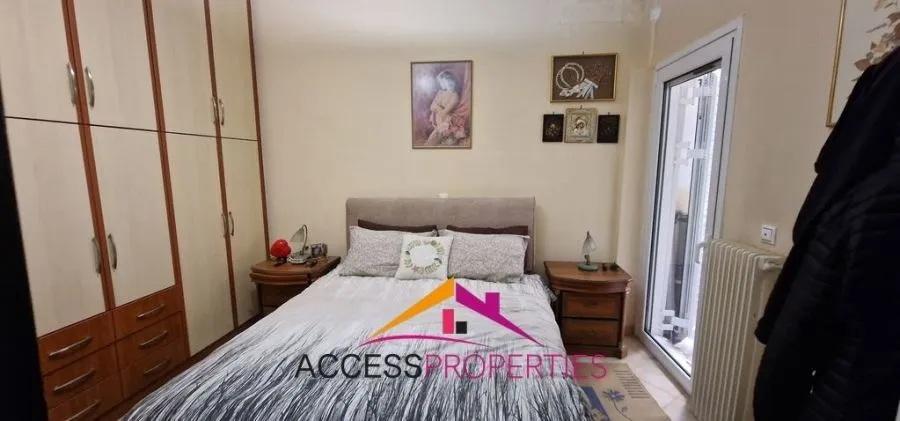

In [ ]:
from IPython.display import Image
Image(filename=images[0])

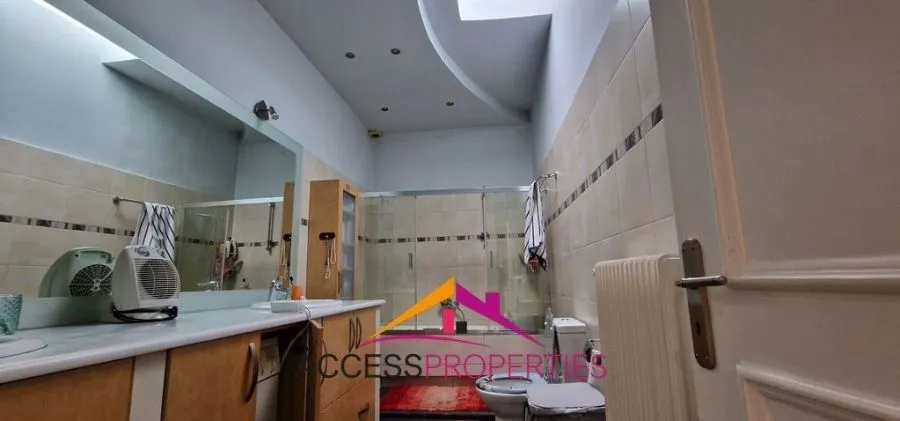

In [ ]:
Image(filename=images[1])

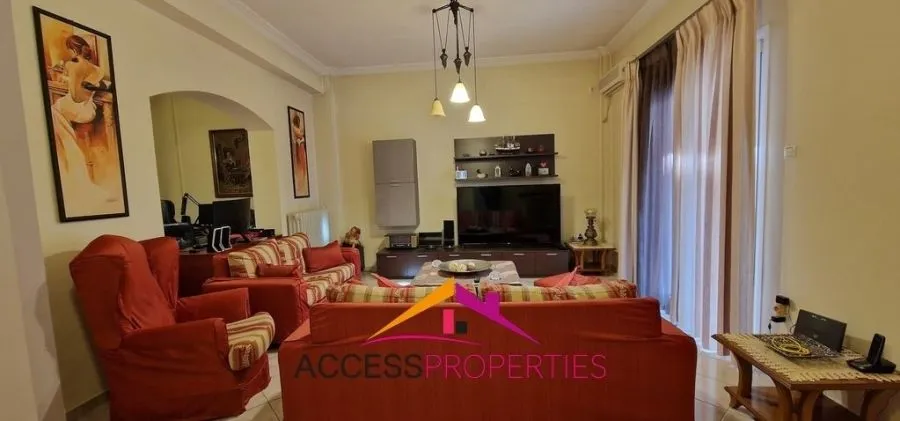

In [ ]:
Image(filename=images[2])

In [ ]:
image_description=house_image_description(images)
image_description

'This house features at least 4 rooms: a loft bedroom, a bathroom, a living area that combines with a dining area, and a smaller bedroom. The flooring type is not explicitly mentioned, but the bathroom contains wooden cabinets and the living area has dark wooden tables and couches, suggesting the presence of wooden elements. The lighting throughout the house is well-lit, with a combination of artificial and natural light sources. In the bathroom, skylights and a glass door provide a significant amount of natural light, while the living area has wall-mounted lights and lamps. The loft bedroom also has lamps that add to the cozy ambiance. The house features various modern and unique elements such as a purple Acer PMP video frame in the living room, multiple TVs, and a fancy lamp, which emphasize the importance of both functionality and appearance in the home design.'

In [ ]:
improved_description=improved_desc(image_description,desc)
print(improved_description)

For sale: A fully renovated apartment in the desirable area of GYZI - ARIOS PAGOS, located on the third floor of an apartment building, with a total area of 75 sq.m. The property features a modern and well-lit interior design with a combination of tile and wood flooring, while the bathroom boasts wooden cabinets. The apartment comprises a living room with dark wooden tables and couches, a kitchen equipped with an oven and stove, an entry room, two rooms (one suitable for use as an office), a communication corridor, and a bright bathroom with skylights and a glass door.

The property benefits from aluminum frames with double glazing, a safety door, air conditioning (2 units), screens on the bathroom side, and awnings, resulting in low utility costs. The apartment's frontage ensures excellent natural light throughout the day. 

Conveniently located within a 10-minute walk to the AMPELOKIPI METRO station, near the Evelpidon Courts, Hospitals, and a main road with frequent public transport

In [ ]:
calculate_similarity_ads(images,desc)

{'lighting_similarity': 1.0000001192092896,
 'flooring_similarity': 0.7784038782119751}

In [ ]:
ad_features=ad_feature_extraction(desc)
print(ad_features)

1. Public transport stations: Yes, it is located a 10-minute walk from AMPELOKIPI METRO station.
2. Amenities: Yes, it is near the Evelpidon Courts, Hospitals, and a main road with frequent public transportation.
3. Layout: Yes, it has a living room, kitchen, entry room, 2 rooms (1 can be used as an office), communication corridor, and bathroom.
4. House type: Yes, it is an apartment.
